# Introduction
The purpose of this workbook is to walkthrough the methods and approach I used to improve the ROI from 0 to 2 for marketing campaigns.  

Whilst the exact details cannot be shared, I demonstrate the challenges and how I overcame them with mocked data.

In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme("onedork")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# pd.options.mode.chained_assignment = None  # default='warn'

# from warnings import simplefilter 
# simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
# pd.set_option("display.max_columns", 500)
# pd.set_option("display.max_rows", 500)
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Background
Whilst working for a multi national telecom company, I was supporting the marketing department to find ways to enhance their marketing.  

The company often contacted their 3.5 million customers via Direct mail with offers to extend or upgrade their products.  

Marketing mix models had suggested that this was not providing return and therefore we needed to understand how we could optimise this.

### Size of the Opportunity
There were numerous rules that existed for determing who was contacted and why.

There were around 1 million customers available to be targeted.  

However if a customer was contacted in the prior month, they were blocked from being contacted again.  

This meant about 500k mails were sent each month (including new business acquisition).  
Each mail cost roughly €1.

In [2]:
# add in some form of calculation that ties the above to the below story.

#show that the total budget was around €6m

### Calcuating ROI
Until this point, the company had measured success based on the number of contracts sold.  
It was therefore not possible to calculate a ROI, or highlight which campaigns were working better than others.  

Therefore, the first task was to create a return calculation.  

The contracts were 24 months long.  Therefore, an average monthly price was calculated and attached to each campaign.  

### Stakeholder Resistance

There had been significant resistance to removing customers from the target group as there were high sales targets.  

However, this very simple approach demonstrated the need for a more data driven approach as there were campaigns which were very negative, and overall the performance of the department was neutral.  


In [ ]:
#Then show that some campaigns were negative vs their costs  
# Literally summarise the campaigns and show the values


### Starting with Test & Learn with Control Groups

To prove the value, control groups were implemented.  
These groups would have been made an offer, but were withheld.  
These control groups still had some conversion via noise and prior contact, and it was expected that the treatment (offer) would have a positive impact.  

One sided proportional Z tests were used to evaluate if the uplift of the treatment was significant.  

Given the aggressive sales targets, the control groups were not of equal size to the treatment group.  
How the control groups were calculated is detailed elsewhere.

In [7]:
df.shape

(70000, 3)

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm


# -------------------------------
# ⚙️ PARAMETERS — adjust as needed
# -------------------------------

n_total = 70000         # Total users in treatment group
true_conversion_rate = 0.0012  # 0.12% conversion rate


# Seed for reproducibility
np.random.seed(42)

# -------------------------------
# 🔢 1. Simulate treatment group
# -------------------------------

# Simulate whether each user converts (1) or not (0)
conversions = np.random.binomial(1, true_conversion_rate, size=n_total)

# Wrap into a DataFrame
df = pd.DataFrame({
    'user_id': np.arange(n_total),
    'converted': conversions
})

# -------------------------------
# 📊 2. Calculate overall conversion rate & significance
# -------------------------------

overall_rate = df['converted'].mean()
overall_successes = df['converted'].sum()
baseline_rate = 0.0006  # Control group conversion rate = 0.06%

# Z-test for difference in proportions
# (This simulates comparing against control group with equal n)
pooled_p = (overall_successes + n_total * baseline_rate) / (2 * n_total)
se = np.sqrt(pooled_p * (1 - pooled_p) * (2 / n_total))
z = (overall_rate - baseline_rate) / se
p_value = norm.sf(z)  # One-sided test

print(f"--- OVERALL TEST ---")
print(f"Conversion rate: {overall_rate:.4%}")
print(f"Z = {z:.2f}, p = {p_value:.4f}")




--- OVERALL TEST ---
Conversion rate: 0.1014%
Z = 2.73, p = 0.0032



--- SPLIT INTO 3 GROUPS ---
Group 1: conv rate = 0.0943%, z = 1.33, p = 0.0911
Group 2: conv rate = 0.1029%, z = 1.62, p = 0.0523
Group 3: conv rate = 0.1071%, z = 1.76, p = 0.0390


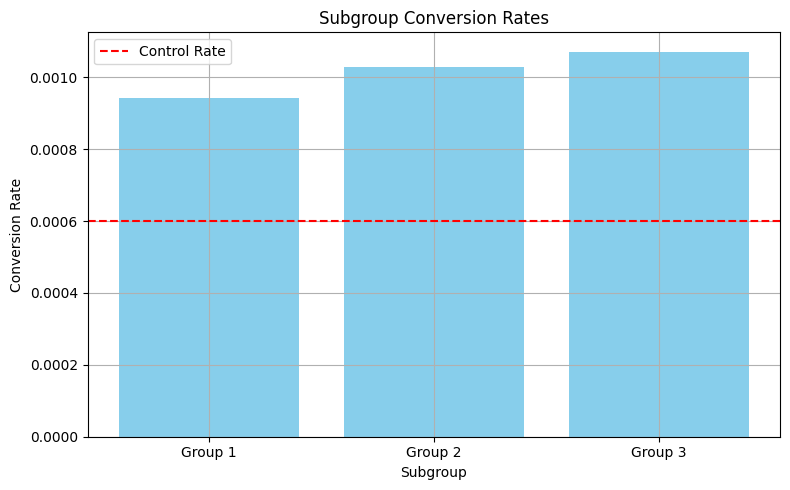

In [6]:
# -------------------------------
# 📦 3. Split into subgroups
# -------------------------------
n_splits = 3            # Number of subgroups to split into
df['subgroup'] = pd.qcut(df['user_id'], n_splits, labels=False)

print(f"\n--- SPLIT INTO {n_splits} GROUPS ---")

subgroup_results = []

for i in range(n_splits):
    group = df[df['subgroup'] == i]
    group_rate = group['converted'].mean()
    group_successes = group['converted'].sum()

    pooled_p = (group_successes + len(group) * baseline_rate) / (2 * len(group))
    se = np.sqrt(pooled_p * (1 - pooled_p) * (2 / len(group)))
    z = (group_rate - baseline_rate) / se
    p = norm.sf(z)

    print(f"Group {i+1}: conv rate = {group_rate:.4%}, z = {z:.2f}, p = {p:.4f}")
    subgroup_results.append(group_rate)

# -------------------------------
# 📈 4. Visualize subgroup conversion rates
# -------------------------------

plt.figure(figsize=(8, 5))
plt.bar(range(n_splits), subgroup_results, color='skyblue')
plt.axhline(y=baseline_rate, color='red', linestyle='--', label='Control Rate')
plt.title('Subgroup Conversion Rates')
plt.xlabel('Subgroup')
plt.ylabel('Conversion Rate')
plt.xticks(range(n_splits), [f"Group {i+1}" for i in range(n_splits)])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
sum(df.converted) / len(df.converted)

0.0010142857142857143

In [12]:
import numpy as np
from scipy.stats import norm

# ------------------------------------
# 📌 INPUTS — adjust as needed
# ------------------------------------
n_control = 70000
n_treatment = 70000

p_control = 0.0006  # 0.06%
p_treatment = 0.0012  # 0.12%

# ------------------------------------
# 🔢 Derived counts
# ------------------------------------
x_control = int(p_control * n_control)
x_treatment = int(p_treatment * n_treatment)

# ------------------------------------
# 🔍 Z-test for difference in proportions
# ------------------------------------
# Pooled proportion under null
p_pooled = (x_control + x_treatment) / (n_control + n_treatment)

# Standard error
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_control + 1/n_treatment))

# Z-statistic
z = (p_treatment - p_control) / se

# One-sided p-value (testing if treatment > control)
p_value = norm.sf(z)

# ------------------------------------
# 📈 Results
# ------------------------------------
print(f"--- Z-Test for Proportions (Overall Validity) ---")
print(f"Control group: {x_control}/{n_control} = {p_control:.4%}")
print(f"Treatment group: {x_treatment}/{n_treatment} = {p_treatment:.4%}")
print(f"Z = {z:.2f}")
print(f"One-sided p-value = {p_value:.5f}")

if p_value < 0.05:
    print("✅ Statistically significant at 95% level (p < 0.05)")
else:
    print("❌ Not statistically significant at 95% level")

--- Z-Test for Proportions (Overall Validity) ---
Control group: 41/70000 = 0.0600%
Treatment group: 83/70000 = 0.1200%
Z = 3.77
One-sided p-value = 0.00008
✅ Statistically significant at 95% level (p < 0.05)


In [20]:
from statsmodels.stats.proportion import proportions_ztest

# Counts of conversions
successes = [42, 84]  # [control, treatment]
nobs = [70000, 70000]  # Number of observations in each group

# One-sided test: H1 = proportion[1] > proportion[0]
z_stat, p_value = proportions_ztest(successes, nobs, alternative='larger')

print(f"Z-statistic: {z_stat:.2f}")
print(f"One-sided p-value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ Statistically significant at 95% confidence level.")
else:
    print("❌ Not statistically significant.")

Z-statistic: -3.74
One-sided p-value: 0.99991
❌ Not statistically significant.


In [26]:
RealP = 1- p_value
print(f"{RealP:.10f}")

0.0000907943


In [18]:
0.0006*70000

41.99999999999999

In [19]:
70000*0.0012

83.99999999999999

In [27]:
# Unequal sample sizes
successes = [18, 85]     # control, treatment
nobs = [30000, 70000]    # smaller control group

z_stat, p_value = proportions_ztest(successes, nobs, alternative='larger')

print(f"Z-statistic: {z_stat:.2f}")
print(f"One-sided p-value: {p_value:.5f}")

Z-statistic: -2.78
One-sided p-value: 0.99724


In [28]:
import numpy as np
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

# ----------------------------
# 📌 Inputs
# ----------------------------

# Control group (used for two-sample test)
n_control = 70000
p_control = 0.0006  # 0.06%
x_control = int(n_control * p_control)

# Treatment group
n_treatment = 70000
p_treatment = 0.0012  # 0.12%
x_treatment = int(n_treatment * p_treatment)

print(f"Control: {x_control}/{n_control} ({p_control:.4%})")
print(f"Treatment: {x_treatment}/{n_treatment} ({p_treatment:.4%})")

# ----------------------------
# ✅ Two-sample z-test
# ----------------------------

successes = [x_control, x_treatment]
nobs = [n_control, n_treatment]

z_2sample, p_2sample = proportions_ztest(successes, nobs, alternative='larger')

# ----------------------------
# ✅ One-sample z-test
# ----------------------------

# Compare treatment rate to known population mean (control rate)
# Standard error under null hypothesis
se_1sample = np.sqrt(p_control * (1 - p_control) / n_treatment)

# Z-score
z_1sample = (p_treatment - p_control) / se_1sample

# One-sided p-value
p_1sample = norm.sf(z_1sample)

# ----------------------------
# 🧾 Results
# ----------------------------

print("\n--- Two-Sample Z-Test (Treatment vs Control) ---")
print(f"Z = {z_2sample:.2f}")
print(f"p-value (one-sided) = {p_2sample:.5f}")

print("\n--- One-Sample Z-Test (Treatment vs Known Baseline) ---")
print(f"Z = {z_1sample:.2f}")
print(f"p-value (one-sided) = {p_1sample:.5f}")

# Interpretation
if p_2sample < 0.05:
    print("\n✅ Two-sample test is statistically significant (p < 0.05)")
else:
    print("\n❌ Two-sample test is NOT statistically significant")

if p_1sample < 0.05:
    print("✅ One-sample test is statistically significant (p < 0.05)")
else:
    print("❌ One-sample test is NOT statistically significant")


Control: 41/70000 (0.0600%)
Treatment: 83/70000 (0.1200%)

--- Two-Sample Z-Test (Treatment vs Control) ---
Z = -3.77
p-value (one-sided) = 0.99992

--- One-Sample Z-Test (Treatment vs Known Baseline) ---
Z = 6.48
p-value (one-sided) = 0.00000

❌ Two-sample test is NOT statistically significant
✅ One-sample test is statistically significant (p < 0.05)


In [29]:
import numpy as np
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

# ----------------------------
# 📌 Inputs
# ----------------------------

# Control group (used for two-sample test)
n_control = 70000
p_control = 0.0006  # 0.06%
x_control = int(n_control * p_control)

# Treatment group
n_treatment = 70000
p_treatment = 0.0012  # 0.12%
x_treatment = int(n_treatment * p_treatment)

print(f"Control: {x_control}/{n_control} ({p_control:.4%})")
print(f"Treatment: {x_treatment}/{n_treatment} ({p_treatment:.4%})")

# ----------------------------
# ✅ Two-sample z-test
# ----------------------------

successes = [x_treatment, x_control ]
nobs = [n_treatment, n_control]

z_2sample, p_2sample = proportions_ztest(successes, nobs, alternative='larger')

# ----------------------------
# ✅ One-sample z-test
# ----------------------------

# Compare treatment rate to known population mean (control rate)
# Standard error under null hypothesis
se_1sample = np.sqrt(p_control * (1 - p_control) / n_treatment)

# Z-score
z_1sample = (p_treatment - p_control) / se_1sample

# One-sided p-value
p_1sample = norm.sf(z_1sample)

# ----------------------------
# 🧾 Results
# ----------------------------

print("\n--- Two-Sample Z-Test (Treatment vs Control) ---")
print(f"Z = {z_2sample:.2f}")
print(f"p-value (one-sided) = {p_2sample:.5f}")

print("\n--- One-Sample Z-Test (Treatment vs Known Baseline) ---")
print(f"Z = {z_1sample:.2f}")
print(f"p-value (one-sided) = {p_1sample:.5f}")

# Interpretation
if p_2sample < 0.05:
    print("\n✅ Two-sample test is statistically significant (p < 0.05)")
else:
    print("\n❌ Two-sample test is NOT statistically significant")

if p_1sample < 0.05:
    print("✅ One-sample test is statistically significant (p < 0.05)")
else:
    print("❌ One-sample test is NOT statistically significant")

Control: 41/70000 (0.0600%)
Treatment: 83/70000 (0.1200%)

--- Two-Sample Z-Test (Treatment vs Control) ---
Z = 3.77
p-value (one-sided) = 0.00008

--- One-Sample Z-Test (Treatment vs Known Baseline) ---
Z = 6.48
p-value (one-sided) = 0.00000

✅ Two-sample test is statistically significant (p < 0.05)
✅ One-sample test is statistically significant (p < 0.05)


Why proportions?
* comparing results of something done at the same time.  Not comparing the mean to the population.  The props is the gold standard approach

What need to factor in when using ztest? What are the requirements for the result to be valid?